In [1]:
# Procesado y tratamiento de los datos
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import RobustScaler, PowerTransformer

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Balanceo del dataset
from imblearn.combine import SMOTEENN

# División del dataset
from sklearn.model_selection import train_test_split

# Búsqueda de los mejores parámetros
from sklearn.model_selection import GridSearchCV

# Modelos utilizados 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Métricas de evaluación
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Otros
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Lectura del dataset 
df = pd.read_csv('classification_in_asteroseismology.csv')
# Visualización inicial del conjunto de datos
df

,POP,Dnu,numax,epsilon
0,1,4.44780,43.06289,0.985
1,0,6.94399,74.07646,0.150
2,1,2.64571,21.57891,0.855
3,1,4.24168,32.13189,0.840
4,0,10.44719,120.37356,0.275
...,...,...,...,...
996,0,5.51582,49.99920,0.060
997,1,4.14823,32.09069,0.930
998,1,3.98294,30.90257,0.880
999,1,4.33893,45.62183,0.975


## Análisis exploratorio de los datos

In [3]:
# Visualizamos la información básica del conjunto de datos
# Indica el número de filas del dataset
# Muestra el número de datos no nulos por columna (valores validos)
# Tipo de dato de cada columna
# Tamaño total del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   POP      1001 non-null   int64  
 1   Dnu      1001 non-null   float64
 2   numax    1001 non-null   float64
 3   epsilon  1001 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 31.4 KB


In [4]:
# Dimensiones del dataset
# Muestra la cantidad de datos y el número de columnas que posee el dataset
df.shape

(1001, 4)

In [5]:
# Validación de datos duplicados
df.duplicated().sum()

0

In [6]:
# Número de datos ausentes por variable
print(df.isnull().sum())

POP        0
Dnu        0
numax      0
epsilon    0
dtype: int64


In [7]:
# Visualización de la información estadística del conjunto de datos
df.describe()

,POP,Dnu,numax,epsilon
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.712288,5.774810,58.441771,0.610774
std,0.452923,2.998103,43.425561,0.342518
min,0.000000,2.500080,17.979780,0.005000
25%,0.000000,4.073160,32.924350,0.220000
50%,1.000000,4.308740,38.293160,0.815000
75%,1.000000,6.580340,70.140830,0.890000
max,1.000000,17.699430,239.648480,1.000000


##### Gráficas de Distribución de los Datos

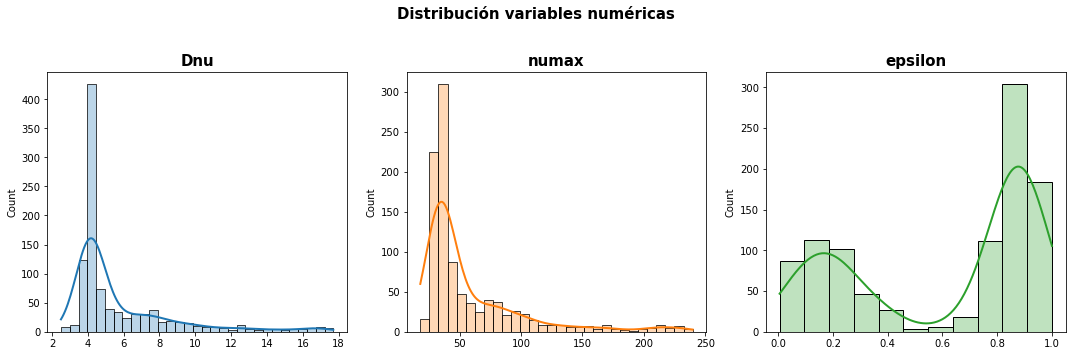

In [8]:
# Gráficas de distribución para cada variable numérica continua
# Ajustar número de subplots en función del número de columnas
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flat
# Seleccionamos el tipo de variable a gráficar
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
# Se elimina la variable de salida
columnas_numeric = columnas_numeric.drop('POP')
# Recorremos cada columna seleccionada 
for i, colum in enumerate(columnas_numeric):
    # Gráficamos cada columna 
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
fig2.tight_layout()
plt.subplots_adjust(top = 0.8)
fig2.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

La gráficas de distribución de las variables refleja lo siguiente:
- Para la variable "Dnu" podemos observar sesgo hacia la derecha, los datos poseen asimetría positiva con un pico no tan pronunciado en la mayor concentración de datos.
- Para la variable "numax" también podemos observar sesgo hacía la derecha, los datos poseen asimetría positiva y en este caso el pico de concentración de datos si es un poco mas pronunciado en comparación a la primera variable.
- Para la variable "epsilon" podemos observar una distribución totalmente diferente en comparación de las otras 2 variables, los datos reflejan una distribución bimodal, con una estructura un poco más homogénea de los datos.

Además que las variables paracen no seguir una distribución normal.

##### Gráficas de Densidad
Para ver un poco más clara la distribución de los datos observemos las siguientes gráficas de densidad:

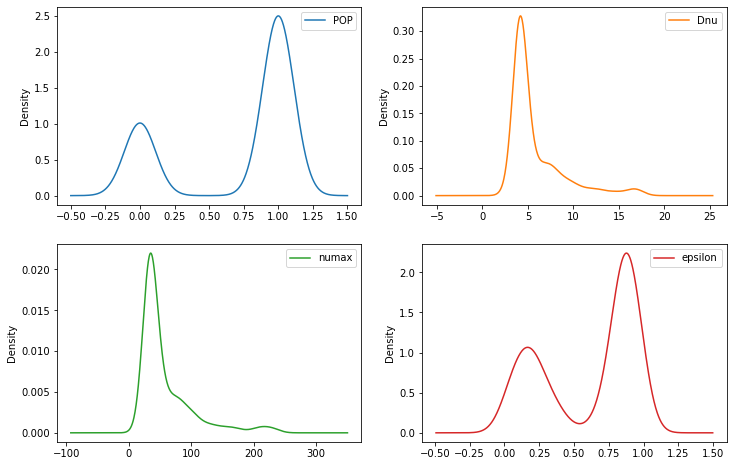

In [9]:
# Gráficas de densidad para cada variable 
fig = plt.figure (figsize = (12,8))
ax = fig.gca()
den=pd.DataFrame(df)
den.plot(ax =ax, kind='density', subplots = True, layout =(2,2), sharex = False)
plt.show()

Como lo reflejaron las gráficas de distribución de datos en las varibles: "Dnu", "numax" podemos ver picos bastantes pronunciados en sus respectivos rangos de concentracion de datos, además que se observan ciertos valores que generan una leve asimetría negativa, generando un poco de sesgo a la izquierda, sin embargo este es mucho menor en comparacióna a la asimetría positiva que presentan ambas variables, por lo que podemos deducir que se podrian tratar de valores atípico presentes en los datos y con mayor presencia en registros con valores altos y una menor cantidad para valores bajos en ambas variables. Para poder verificar lo indicado anteriormete más adelante estaremos haciendo una inspección para la búsqueda de valores atípicos.

En variable "epsilon" podemos ver las mismas observaciones que en la gráfica anterior, presenta una distribución bimodal, con una curva un poco más grande y pronunciada en la segunda concetración de datos y una curva mas pequeña y menos produnciada en la primera concetración de datos, sin embargo con una distribución bastante homogénea en ambos casos, sus picos a los lados son menos alargados, no se observan sesgos significativos en ambos lados, por lo que es muy posible que los valores atípicos sean muy pocos o no los hayan.

#### Mapa de calor de correlaciones

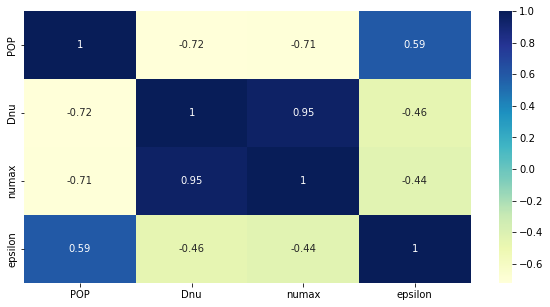

In [12]:
# Validación de correlaciones
correlation = df.corr(method='spearman')
fig1 = plt.figure(figsize=(10,5))
ax = fig1.add_subplot(111)
sns.heatmap(correlation, cmap="YlGnBu", annot=True)
plt.show()

#### Búsqueda y Análisis de Outliers

<Figure size 432x288 with 0 Axes>

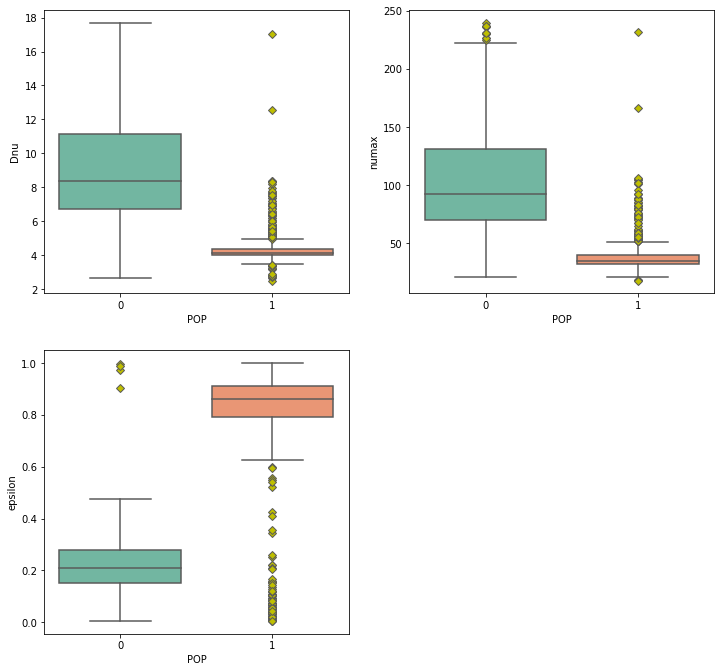

In [13]:
# Boxplot por cada variable
den=pd.DataFrame(df)
plt.figure (4)
plt.subplots(figsize=(12,24))
green_diamond = dict(markerfacecolor='y', marker='D')
sns.set_palette("Set2")

plt.subplot(421)
sns.boxplot(x='POP', y='Dnu', data=den, flierprops=green_diamond)

plt.subplot(422)
sns.boxplot(x='POP', y='numax', data=den, flierprops=green_diamond)

plt.subplot(423)
sns.boxplot(x='POP', y='epsilon', data=den, flierprops=green_diamond)

plt.show() 

La primera búsqueda de posibles outliers en nuestros datos a traves de gráficas de caja, reflejan la presencia de algunos datos que podrían considerarse atípicos, ya que quedan fuera del limite inferior o superior de los datos, además de podemos ver que en las tres variables los rangos intecuartílicos no se sobreponen, lo que indica una clara separación para ambas clases.

Para poder verificar mas claramente si hay o no valores atipicos en nuestros datos vamos hacer uso del método de Tukey o bloxplot el cual consiste en definir los límites inferior y superior a partir del rango intercuartílico (IQR) el primer cuartil (Q1) y el tercer cuartil (Q3). A continuación definiremos la función que se encargara del cálculo de límite inferior y superiro de cada variable.

In [14]:
# Función que calcula los valores del límite inferior y superior en las variables numericas
# Para poder identificar y analizar los posibles outliers que las varibles puedan contener
def calcula_limites(data,ft):
    # Cálculamos los valores de los cuartiles
    Q1 = data[ft].quantile(0.25)
    Q3 = data[ft].quantile(0.75)
    # Cálculamos el rango intercuartílico 
    IQR = Q3 - Q1
    # Cálculamos los valores de los bigotes inferior y superior
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    # Impimimos los valores cálculados
    print(f"El límite inferior es {lower_bound} y el límite superior {upper_bound}")
    # Retornamos los valores del límite inferior y superior
    return lower_bound, upper_bound

In [15]:
# Ejecutamos la función para definir el limite inferior y superior en la variable "Dnu"
lower_bound, upper_bound = calcula_limites(df,'Dnu')

El límite inferior es 0.3123899999999997 y el límite superior 10.34111


In [16]:
# Buscamos y separamos los valores que sean menores al límite inferior y mayores que el limite superior
# Para validar los posibles outliers que se vizualizan en la gráfica de caja anteriror
Outliers_Dnu = df.query('(Dnu > @upper_bound) | (Dnu < @lower_bound)')
# Visualización de los valores encontrados
Outliers_Dnu

,POP,Dnu,numax,epsilon
4,0,10.44719,120.37356,0.275
37,0,11.28055,129.58759,0.320
58,0,10.36221,123.53948,0.250
61,0,10.62177,136.73959,0.240
63,0,12.58911,152.48999,0.345
...,...,...,...,...
829,0,17.41007,230.53819,0.410
846,0,15.40096,209.34905,0.380
863,0,16.54784,220.99048,0.385
931,0,16.50862,210.76879,0.360


In [17]:
# Visualización de la información estadística del conjunto de datos
Outliers_Dnu.describe()

,POP,Dnu,numax,epsilon
count,86.000000,86.000000,86.000000,86.000000
mean,0.023256,13.851620,175.891426,0.330233
std,0.151599,2.341019,37.881733,0.061591
min,0.000000,10.362210,117.105320,0.165000
25%,0.000000,11.802795,141.179775,0.285000
50%,0.000000,13.682160,168.036915,0.330000
75%,0.000000,16.219195,213.399497,0.380000
max,1.000000,17.699430,239.648480,0.475000


In [18]:
# Reemplazamos los valores que se encuntre fuera de los rangos
# por el límite superior o inferior según sea el caso 
df.loc[df['Dnu'] > upper_bound, 'Dnu'] = upper_bound
df.loc[df['Dnu'] < lower_bound, 'Dnu'] = lower_bound

In [19]:
# Ejecutamos la función para definir el limite inferior y superior en la variable "numax"
lower_bound, upper_bound = calcula_limites(df,'numax')

El límite inferior es -22.900370000000002 y el límite superior 125.96555


In [20]:
# Buscamos y separamos los valores que sean menores al límite inferior y mayores que el limite superior
# Para validar los posibles outliers que se vizualizan en la gráfica de caja anteriror
Outliers_numax = df.query('(numax > @upper_bound) | (numax < @lower_bound)')
# Visualización de los valores encontrados
Outliers_numax

,POP,Dnu,numax,epsilon
37,0,10.34111,129.58759,0.320
61,0,10.34111,136.73959,0.240
63,0,10.34111,152.48999,0.345
87,0,10.34111,130.69264,0.270
95,0,10.34111,239.64848,0.475
...,...,...,...,...
829,0,10.34111,230.53819,0.410
846,0,10.34111,209.34905,0.380
863,0,10.34111,220.99048,0.385
931,0,10.34111,210.76879,0.360


In [21]:
# Visualización de la información estadística del conjunto de datos
Outliers_numax.describe()

,POP,Dnu,numax,epsilon
count,81.000000,81.000000,81.000000,81.000000
mean,0.024691,10.334988,179.405143,0.333704
std,0.156150,0.055099,36.192447,0.062173
min,0.000000,9.845220,126.339890,0.165000
25%,0.000000,10.341110,146.047080,0.290000
50%,0.000000,10.341110,171.987100,0.340000
75%,0.000000,10.341110,214.303010,0.380000
max,1.000000,10.341110,239.648480,0.475000


In [22]:
# Reemplazamos los valores que se encuntre fuera de los rangos
# por el límite superior o inferior según sea el caso 
df.loc[df['numax'] > upper_bound, 'numax'] = upper_bound
df.loc[df['numax'] < lower_bound, 'numax'] = lower_bound

In [23]:
# Ejecutamos la función para definir el limite inferior y superior en la variable "epsilon"
lower_bound, upper_bound = calcula_limites(df,'epsilon')

El límite inferior es -0.7850000000000001 y el límite superior 1.895


In [24]:
# Buscamos y separamos los valores que sean menores al límite inferior y mayores que el limite superior
# Para validar los posibles outliers que se vizualizan en la gráfica de caja anteriror
Outliers_epsilon = df.query('(epsilon > @upper_bound) | (epsilon < @lower_bound)')
# Visualización de los valores encontrados
Outliers_epsilon

,POP,Dnu,numax,epsilon


Como los habíamos indicado anteriormente en las gráficas de densidad, los valores atípicos parecían concentrarse al lado derecho, en valores mas altos de las variables "Dnu" y "numax" y al realizar la búsqueda de valores que estuviera fuera del límite inferior y superior, se localizaron 86 valores mayores al límite superior en la variable Dnu y 81 valores valores mayores al límite superior en la variable numax, todos estos valores fueron reemplazados por el valor de límite superior, cabe mencionar que se realizaron pruebas conservando dichos valores e iliminadolos, sim embargo los modelos se comportaron mejor con el procedimento aplicado.

 Para la variable epsilon aunque se ven reflejados algunos outliers en la gráfica de caja anterior, al buscar valores que sean menores al límite inferior o mayores al límite superior, no se localizan registros que cumplan con las condiciones definidas, por lo que no se aplico ningún proceso a dicha variable.

 A continuación podemos observar nuevamente las gráficas de caja de cada variable con los cambios aplicados. 

<Figure size 432x288 with 0 Axes>

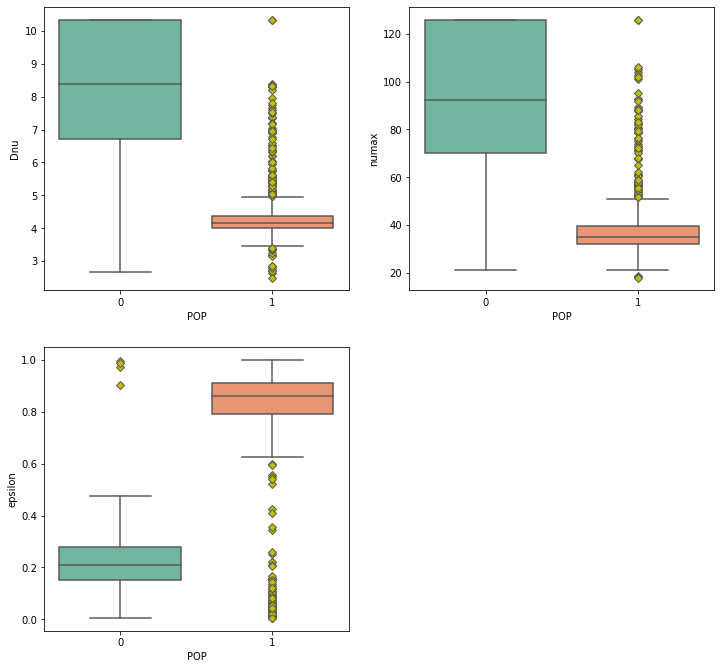

In [25]:
# Boxplot por cada variable
den=pd.DataFrame(df)
plt.figure (5)
plt.subplots(figsize=(12,24))
green_diamond = dict(markerfacecolor='y', marker='D')
sns.set_palette("Set2")

plt.subplot(421)
sns.boxplot(x='POP', y='Dnu', data=den, flierprops=green_diamond)

plt.subplot(422)
sns.boxplot(x='POP', y='numax', data=den, flierprops=green_diamond)

plt.subplot(423)
sns.boxplot(x='POP', y='epsilon', data=den, flierprops=green_diamond)

plt.show() 

## División del conjunto de datos

In [26]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [27]:
# Division del conjunto de datos en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(df, stratify='POP')

In [28]:
# Verificamos las particiones realizadas
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 600
Longitud del Validation Set: 200
Longitud del Test Set: 201


In [29]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("POP", axis=1)
y_train = train_set["POP"].copy()

In [30]:
# Conjunto de datos de pruebas
X_val = val_set.drop("POP", axis=1)
y_val = val_set["POP"].copy()

In [31]:
# Conjunto de datos de test
X_test = test_set.drop("POP", axis=1)
y_test = test_set["POP"].copy()

## Balanceo del dataset

In [32]:
#Validación de la cantidad de ejemplos que posee el dataset segun la variable de salida.
train_set["POP"].value_counts()

1    427
0    173
Name: POP, dtype: int64

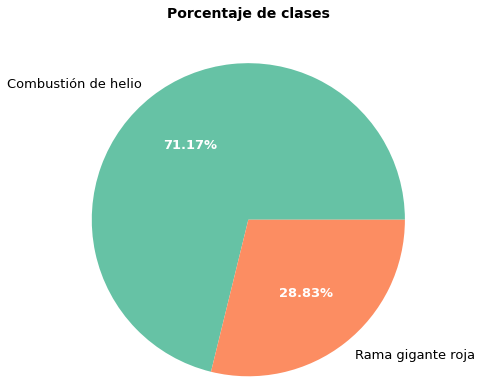

In [33]:
#Creación de una gráfica para representar el porcentaje de las observaciones por clase
Gender = train_set['POP'].value_counts()
names = 'Combustión de helio','Rama gigante roja'
fig5, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=Gender, labels=names, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("Set2"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Porcentaje de clases', y=1.1,  weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

El conjunto de datos posee un desbalance con 427 datos de combustión de helio y 173 de ramas gigantes rojas, al entrenar los diferentes algoritmos generaria una matriz de confusión desbalanceda, por lo que se hara uso de la técnica "SMOTEENN" la cual combina el sobremuestreo con SMOTE y submuestreo con Edited Nearest Neighbours.

In [34]:
# Inicialización del método combinado
smote_enn = SMOTEENN(random_state=0)#random_state = 0
#Sobremuestreo con Smote seguido de un submuestreo con Edited Nearest Neighbours
X_smote_enn, y_smote_enn = smote_enn.fit_resample(X_train, y_train)
CH_smote_enn = y_smote_enn.sum()
RGR_smote_enn = y_smote_enn.shape[0]- CH_smote_enn
print('Rama gigante roja: ', RGR_smote_enn, ' , Combustión de helio: ', CH_smote_enn)
X_smote_enn

Rama gigante roja:  387  , Combustión de helio:  375


,Dnu,numax,epsilon
0,10.34111,125.96555,0.410
1,6.92475,67.30475,0.170
2,8.96626,97.39633,0.215
3,6.37037,63.50017,0.095
4,10.34111,125.96555,0.425
...,...,...,...
757,3.66671,29.22274,0.880
758,4.21811,42.99284,0.910
759,3.41101,26.40331,0.785
760,4.31385,38.71001,0.880


## Escalado y transformación de los datos

In [35]:
# Pipeline que se encarga del escalado y transformación de los datos
# Definimos las columnas que seran escaladas y transformadas
columns = ['Dnu', 'numax', 'epsilon']
# Se definen los procesos que deberán ser aplicados
columns_transformers = Pipeline(
                        steps=[
                            ('robust', RobustScaler()),
                            ('yeo', PowerTransformer(method='yeo-johnson'))
                        ]
                      )
# Se aplican los procesos a las columnas seleccionadas
preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', columns_transformers, columns)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               )
# Se ajusta y transforma el conjunto de datos de entrenamiento
X_train_transformed = preprocessor.fit_transform(X_smote_enn)
# Se aplican las mismas transformaciones al conjunto de datos de pruebas y validación
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

In [36]:
# Visualmente nuestro pipepline luce así:
set_config(display='diagram')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('robust', RobustScaler()),
                                                 ('yeo', PowerTransformer())]),
                                 ['Dnu', 'numax', 'epsilon'])],
                  verbose_feature_names_out=False)

In [37]:
# Obtenemos los nombres de las columnas después del tranformación 
transformed_feature_names = list(preprocessor.get_feature_names_out(input_features=X_smote_enn.columns))
# Convertimos la matriz transformada en un DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)

In [38]:
# Unimos nuevamente la variable de salida al dataset 
# Para poder validar correlaciones después de las tranformaciones aplicadas
data_clean= pd.concat([X_train_transformed_df, y_smote_enn], axis=1,sort=True)
# Visualizamos los cambios aplicados
data_clean

,Dnu,numax,epsilon,POP
0,1.364513,1.404881,-0.223653,0
1,0.461745,0.296570,-1.091626,0
2,1.060814,0.964770,-0.916383,0
3,0.253037,0.188019,-1.395864,0
4,1.364513,1.404881,-0.174981,0
...,...,...,...,...
757,-1.284210,-1.217248,1.078370,1
758,-0.887571,-0.550179,1.149668,1
759,-1.483567,-1.371816,0.845050,1
760,-0.823266,-0.742259,1.078370,1


In [39]:
# Calculamos la matriz de correlación
correlation_matrix = data_clean.corr()
# Visualizamos la matriz de correlación 
print(correlation_matrix)

              Dnu     numax   epsilon       POP
Dnu      1.000000  0.995040 -0.745249 -0.936019
numax    0.995040  1.000000 -0.728142 -0.925137
epsilon -0.745249 -0.728142  1.000000  0.870659
POP     -0.936019 -0.925137  0.870659  1.000000


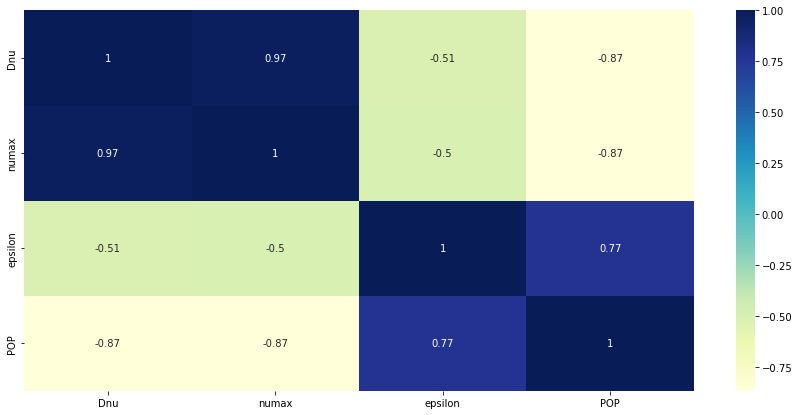

In [40]:
# Validación de correlaciones
correlation = data_clean.corr(method='spearman')
fig1 = plt.figure(figsize=(15,7))
ax = fig1.add_subplot(111)
sns.heatmap(correlation, cmap="YlGnBu", annot=True)
plt.show()

## Selección de los mejores modelos

In [41]:
# Pruebas con diferentes modelos 
models = []
models.append(['Logistic Regreesion', LogisticRegression()])
models.append(['SVM', SVC()])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['Decision Tree', DecisionTreeClassifier()])
models.append(['Random Forest', RandomForestClassifier()])
models.append(['Ada Boost', AdaBoostClassifier()])

# Entrenamiento de los diferentes modelos
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kFold = KFold(n_splits=5, random_state=3, shuffle=True)
    cv_results = cross_val_score(model, X_train_transformed, y_smote_enn, cv=kFold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    # Evaluación de los diferentes modelos
    print(f"{name}: {cv_results.mean()*100.0:,.2f}% ({cv_results.std()*100.0:,.2f}%)")

Logistic Regreesion: 99.87% (0.26%)
SVM: 99.87% (0.26%)
KNeighbors: 99.87% (0.26%)
GaussianNB: 100.00% (0.00%)
BernoulliNB: 97.77% (0.98%)
Decision Tree: 100.00% (0.00%)
Random Forest: 99.87% (0.26%)
Ada Boost: 99.87% (0.26%)


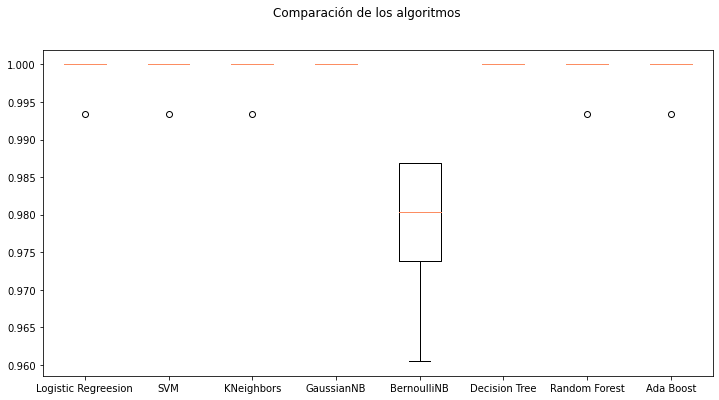

In [42]:
# Gráfica de caja para verificar el rendimiento de los diferentes modelos probados 
fig14 = plt.figure(figsize =(12,6))
fig14.suptitle('Comparación de los algoritmos')
ax = fig14.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Hiperparametrización de los mejores modelos

In [43]:
# Búsqueda de los mejores parámetros para "K-Neighbors"
parameters1 = {"n_neighbors" : [1,3,5],
              "weights": ["uniform", "distance", None],
              "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
              }

model_KNN = KNeighborsClassifier()
kFold = KFold(n_splits=5, random_state=3, shuffle=True)

grid = GridSearchCV(estimator=model_KNN, param_grid=parameters1, cv=kFold, return_train_score=True)
grid_result1= grid.fit(X_train_transformed, y_smote_enn)

# mejores parámetros
grid_result1.best_params_

{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}

In [44]:
# Búsqueda de los mejores parámetros para "Árboles de decisión"
parameters2 = {"max_depth": [1, 2, 3, None],
              "splitter": ["best", "random"],
              "max_features": [1, 2, 3, "sqrt", "log2"],
              "criterion": ["gini", "entropy", "log_loss"]
              }

model_DTC = DecisionTreeClassifier()
kFold = KFold(n_splits=5, random_state=3, shuffle=True)

grid2 = GridSearchCV(estimator=model_DTC, param_grid=parameters2, cv=kFold, return_train_score=True)
grid_result2= grid2.fit(X_train_transformed, y_smote_enn)

# mejores parámetros
grid_result2.best_params_

{'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'splitter': 'best'}

In [45]:
# Búsqueda de los mejores parámetros para "Bosques aleatorios"
parameters3 = {"max_depth": [1, 2, 3, None],
              "max_features": [1, 2, 3, "sqrt", "log2"],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy", "log_loss"]
              }

model_RFC = RandomForestClassifier()
kFold = KFold(n_splits=5, random_state=3, shuffle=True)

grid3 = GridSearchCV(estimator=model_RFC, param_grid=parameters3, cv=kFold, return_train_score=True)
grid_result3= grid3.fit(X_train_transformed, y_smote_enn)

# mejores parámetros
grid_result3.best_params_

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 2}

## Evaluación del mejor modelo

In [46]:
# Prueba de los mejores modelos con los parámetros encontrados
models_hiper = []
models_hiper.append(['KNeighbors', KNeighborsClassifier(**grid_result1.best_params_)])
models_hiper.append(['Decision Tree', DecisionTreeClassifier(**grid_result2.best_params_)])
models_hiper.append(['Random Forest', RandomForestClassifier(**grid_result3.best_params_)])

# Entrenamiento de los modelos
results2 = []
names2 = []
scoring2 = 'accuracy'
for name, model2 in models_hiper:
    kFold = KFold(n_splits=5, random_state=3, shuffle=True)
    cv_results2 = cross_val_score(model2, X_train_transformed, y_smote_enn, cv=kFold, scoring=scoring2)
    results2.append(cv_results2)
    names2.append(name)
    # Evaluación de los diferentes modelos
    print(f"{name}: {cv_results2.mean()*100.0:,.2f}% ({cv_results2.std()*100.0:,.2f}%)")

KNeighbors: 99.87% (0.26%)
Decision Tree: 99.74% (0.32%)
Random Forest: 99.87% (0.26%)


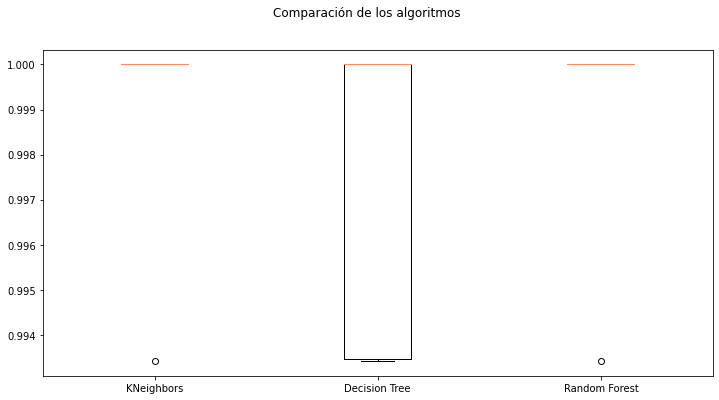

In [47]:
# Gráfica de caja para verificar el rendimiento de los diferentes modelos probados 
fig15 = plt.figure(figsize =(12,6))
fig15.suptitle('Comparación de los algoritmos')
ax = fig15.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()

In [48]:
# Entrenamiento y prueba con el mejor modelo 
# Inicializamos el modelo 
mejor_modelo = RandomForestClassifier(**grid_result3.best_params_)
# Le pasamos los datos de entrenamiento 
mejor_modelo.fit(X_train_transformed, y_smote_enn)

# Realizamos una nueva predición con los datos de prueba
y_pred = mejor_modelo.predict(X_val_transformed)

# Evaluamos el rendimiento del modelo con los datos de prueba 
accuracy_score(y_val, y_pred)

0.94

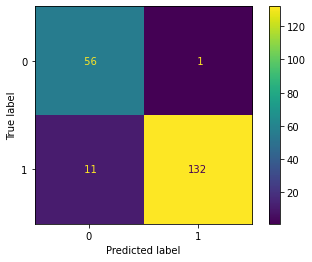

In [49]:
# Resultados de la matriz de confusión con los datos de prueba 
plot_confusion_matrix(mejor_modelo, X_val_transformed, y_val, values_format='3g')

In [50]:
# Reporte de los resultados que se obtuvieron con los datos de prueba 
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90        57
           1       0.99      0.92      0.96       143

    accuracy                           0.94       200
   macro avg       0.91      0.95      0.93       200
weighted avg       0.95      0.94      0.94       200



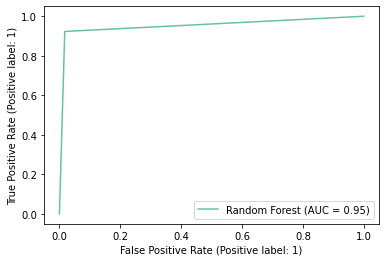

In [51]:
# Curva ROC para los datos de prueba
RocCurveDisplay.from_predictions(y_val, y_pred, name="Random Forest")
plt.show()

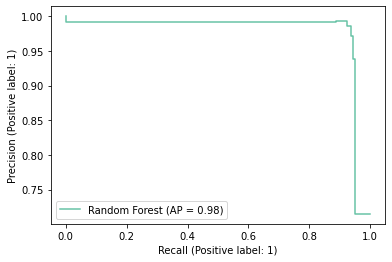

In [52]:
# Curva PR para los datos de prueba
PrecisionRecallDisplay.from_estimator(mejor_modelo, X_val_transformed, y_val, name="Random Forest")

In [53]:
# Realizamos una nueva predición con los datos de test
y_pred2 = mejor_modelo.predict(X_test_transformed)

# Evaluamos el rendimiento del modelo con los datos de test
accuracy_score(y_test, y_pred2)

0.9402985074626866

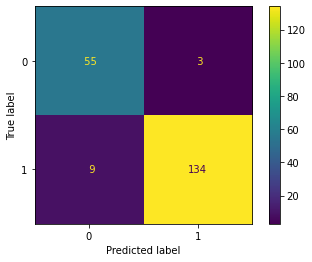

In [54]:
# Resultados de la matriz de confusión con los datos de test
plot_confusion_matrix(mejor_modelo, X_test_transformed, y_test, values_format='3g')

In [55]:
# Reporte de los resultados que se obtuvieron con los datos de test
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        58
           1       0.98      0.94      0.96       143

    accuracy                           0.94       201
   macro avg       0.92      0.94      0.93       201
weighted avg       0.94      0.94      0.94       201



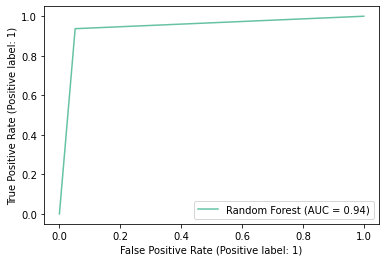

In [56]:
# Curva ROC para los datos de test
RocCurveDisplay.from_predictions(y_test, y_pred2, name="Random Forest")
plt.show()

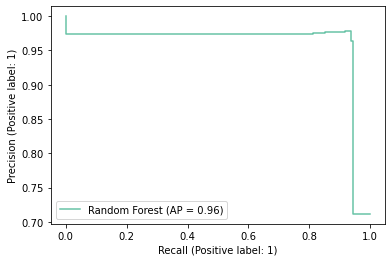

In [57]:
# Curva PR para los datos de test
PrecisionRecallDisplay.from_estimator(mejor_modelo, X_test_transformed, y_test, name="Random Forest")